In [1]:
# 標準ライブラリ
import gc
import os
import pickle
import random
import sys
import warnings
from itertools import combinations, permutations
from pathlib import Path
import pytz

# サードパーティのライブラリ
import category_encoders as ce
import joblib
import lightgbm as lgb
import numpy as np
import pandas as pd
import polars as pl
import scipy as sp
import seaborn as sns
import torch
import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from dateutil.relativedelta import relativedelta
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.impute import KNNImputer
from sklearn.metrics import f1_score, log_loss, matthews_corrcoef, roc_auc_score
from sklearn.model_selection import (GroupKFold, KFold, StratifiedKFold,
                                     StratifiedGroupKFold, TimeSeriesSplit,
                                     train_test_split)
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

import glob
import datetime

In [2]:
class CFG:
    home_directory = os.path.expanduser('~/kaggle_HomeCredit/')
    kaggle_directory = os.path.expanduser('/kaggle/input/home-credit-credit-risk-model-stability/')
    
    train_data_path = os.path.join(home_directory, 'train/')
    test_data_path = os.path.join(home_directory, 'test/')
    
    OOF_DATA_PATH = Path(home_directory) / 'oof'
    MODEL_DATA_PATH = Path(home_directory) / 'models'
    SUB_DATA_PATH = Path(home_directory) / 'submission'

    def __init__(self):
        self.create_directories()
    
    def create_directories(self):
        for path in [self.OOF_DATA_PATH, self.MODEL_DATA_PATH, self.SUB_DATA_PATH]:
            path.mkdir(parents=True, exist_ok=True)
    
    
    VER = 'after'
    AUTHOR = 'Mira'
    COMPETITION = 'HomeCredit'

    METHOD_LIST = ['lightgbm']
    seed = 28
    n_folds = 5
    target_col = 'target'
    metric = 'auc'
    
    metric_maximize_flag = True
    num_boost_round = 2000
    early_stopping_round = 200
    verbose = 25
    classification_lgb_params = {
        "boosting_type": "gbdt",
        "objective": "binary",
        "metric": "auc",
        "max_depth": 10,  
        "learning_rate": 0.05,
        "n_estimators": num_boost_round,  
        "colsample_bytree": 0.8,
        "colsample_bynode": 0.8,
        "verbose": 1,
        "reg_alpha": 0.1,
        "reg_lambda": 10,
        "extra_trees":True,
        'num_leaves':64,
        'seed': seed,
    }
    classification_xgb_params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': 0.05,
        'random_state': seed,
        "tree_method": "gpu_hist",
    }

    classification_cat_params = {
        'iterations':num_boost_round,                
        'learning_rate':0.05,
        'depth':10,                     
        'l2_leaf_reg':10,                  
        'loss_function':'Logloss',        
        'eval_metric':'AUC',              
        'bootstrap_type':'Bernoulli',    
        'subsample':0.8,                  
        'colsample_bylevel':0.8,         
        'verbose':False,                  
        'leaf_estimation_iterations':10,       
        'random_seed':seed,
        #"task_type": "GPU",
    }
    #model_weight_dict = {'lightgbm': 0.5,'catboost':0.5}
    model_weight_dict = {'lightgbm': 1}
    

class is_kaggle:
    def __init__(self, Kaggle):
        if Kaggle == "Yes":
            self.path = Path(CFG.kaggle_directory)
            CFG.MODEL_DATA_PATH = Path('/kaggle/input/05102153/models')
        else:
            self.path = Path(CFG.home_directory)
            CFG.MODEL_DATA_PATH = Path(CFG.home_directory) / 'models'

def create_timestamped_file():
    tz_tokyo = pytz.timezone('Asia/Tokyo')
    now = datetime.datetime.now(tz=tz_tokyo)
    filename = now.strftime('%m%d-%H%M') + '.txt'
    full_path = CFG.MODEL_DATA_PATH / filename
    full_path.touch()

create_timestamped_file()
cfg_instance = CFG()      
selector = is_kaggle("No")

In [3]:
class Pipeline:
    @staticmethod
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int32))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))            

        return df
    
    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                df = df.with_columns(pl.col(col).cast(pl.Float32))
                
        df = df.drop("date_decision", "MONTH")

        return df
    
    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

In [4]:
class Aggregator:
    # Please add or subtract features yourself, be aware that too many features will take up too much space.
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        # expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        expr_median = [pl.median(col).alias(f"median_{col}") for col in cols]
        expr_var = [pl.var(col).alias(f"var_{col}") for col in cols]

        return expr_max + expr_last + expr_mean 

    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        # expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        # expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        expr_median = [pl.median(col).alias(f"median_{col}") for col in cols]

        return expr_max + expr_last + expr_mean 

    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        # expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        # expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        # expr_count = [pl.count(col).alias(f"count_{col}") for col in cols]
        return expr_max + expr_last  # +expr_count

    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        # expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        # expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return expr_max + expr_last

    
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        # expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        # expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return expr_max + expr_last

    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

In [5]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    
    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
    
    return df

def read_files(regex_path, depth=None):
    chunks = []
    for path in glob.glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        
        chunks.append(df)
        
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    
    return df

In [6]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
        
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
        
    df_base = df_base.pipe(Pipeline.handle_dates)
    
    return df_base

In [7]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()

    # bool型の列をint型に変換
    bool_cols = df_data.select_dtypes('bool').columns
    df_data[bool_cols] = df_data[bool_cols].astype(int)

    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    
    return df_data, cat_cols


In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [9]:
ROOT = selector.path
TRAIN_DIR       = ROOT / "parquet_files/train"
TEST_DIR        = ROOT / "parquet_files/test"
SAMPLE_SUB = ROOT / "sample_submission.csv"

In [10]:
train_data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
    ]
}

In [11]:
test_data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
    ]
}

In [12]:
def lightgbm_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame, features: list):
    cat_features = x_train.select_dtypes('category').columns.tolist()
    lgb_train = lgb.Dataset(x_train, y_train,categorical_feature=cat_features)
    lgb_valid = lgb.Dataset(x_valid, y_valid,categorical_feature=cat_features)
    model = lgb.train(
                params = CFG.classification_lgb_params,
                train_set = lgb_train,
                num_boost_round = CFG.num_boost_round,
                valid_sets = [lgb_train, lgb_valid],
                #feval = CFG.metric,
                callbacks=[lgb.early_stopping(stopping_rounds=CFG.early_stopping_round,
                                              verbose=CFG.verbose)]
            )
    valid_pred = model.predict(x_valid)
    
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importance(importance_type='gain')
    })
    importance_df['importance'] = importance_df['importance'] / np.sum(importance_df['importance'])
    importance_df = importance_df.sort_values(by='importance', ascending=False)
    print(importance_df)
    return model, valid_pred
def xgboost_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame, features: list):
    xgb_train = xgb.DMatrix(data=x_train, label=y_train)
    xgb_valid = xgb.DMatrix(data=x_valid, label=y_valid)
    model = xgb.train(
                CFG.classification_xgb_params,
                dtrain = xgb_train,
                num_boost_round = CFG.num_boost_round,
                evals = [(xgb_train, 'train'), (xgb_valid, 'eval')],
                early_stopping_rounds = CFG.early_stopping_round,
                verbose_eval = CFG.verbose,
                #feval = CFG.metric,
                maximize = CFG.metric_maximize_flag,
        )
    valid_pred = model.predict(xgb.DMatrix(x_valid))
    return model, valid_pred
def catboost_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame, features: list):
    cat_features = x_train.select_dtypes('category').columns.tolist()
    cat_train = Pool(data=x_train, label=y_train,cat_features=cat_features)
    cat_valid = Pool(data=x_valid, label=y_valid,cat_features=cat_features)
    model = CatBoostClassifier(**CFG.classification_cat_params)
    model.fit(cat_train,
              eval_set = [cat_valid],
              early_stopping_rounds = CFG.early_stopping_round,
              verbose = CFG.verbose,
              use_best_model = True)
    valid_pred = model.predict_proba(x_valid)[:, 1]
    return model, valid_pred

In [13]:
def gradient_boosting_model_cv_training(method: str, train_df: pd.DataFrame, features: list):
    weeks = train_df["WEEK_NUM"]
    X = train_df.drop(columns=["target", "case_id", "WEEK_NUM"])
    y = train_df["target"]
    
    oof_predictions = np.zeros(len(train_df))
    oof_fold = np.zeros(len(train_df))
    cv = StratifiedGroupKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
    for fold, (train_index, valid_index) in enumerate(cv.split(X, y, groups=weeks)):
        print('-'*50)
        print(f'{method} training fold {fold+1}')

        x_train = train_df[features].iloc[train_index]
        y_train = train_df[CFG.target_col].iloc[train_index]
        x_valid = train_df[features].iloc[valid_index]
        y_valid = train_df[CFG.target_col].iloc[valid_index]
        if method == 'lightgbm':
            model, valid_pred = lightgbm_training(x_train, y_train, x_valid, y_valid, features)
        if method == 'xgboost':
            model, valid_pred = xgboost_training(x_train, y_train, x_valid, y_valid, features)
        if method == 'catboost':
            model, valid_pred = catboost_training(x_train, y_train, x_valid, y_valid, features)

        pickle.dump(model, open(CFG.MODEL_DATA_PATH / f'{method}_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl', 'wb'))

        oof_predictions[valid_index] = valid_pred
        oof_fold[valid_index] = fold + 1
        del x_train, x_valid, y_train, y_valid, model, valid_pred
        gc.collect()

    score = roc_auc_score(train_df[CFG.target_col], oof_predictions)
    print(f'{method} our out of folds CV f1score is {score}')

    oof_df = pd.DataFrame({CFG.target_col: train_df[CFG.target_col], f'{method}_prediction': oof_predictions, 'fold': oof_fold})
    oof_df.to_csv(CFG.OOF_DATA_PATH / f'oof_{method}_seed{CFG.seed}_ver{CFG.VER}.csv', index = False)

def Learning(input_df: pd.DataFrame, features: list):
    for method in CFG.METHOD_LIST:
        gradient_boosting_model_cv_training(method, input_df, features)

In [14]:
def unified_inference(method: str, x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for fold in range(CFG.n_folds):
        model_path = CFG.MODEL_DATA_PATH / f'{method}_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl'
        model = pickle.load(open(model_path, 'rb'))

        if method == 'lightgbm':
            pred = model.predict(x_test)
        elif method == 'xgboost':
            pred = model.predict(xgb.DMatrix(x_test))
        elif method == 'catboost':
            pred = model.predict_proba(x_test)[:, 1]
        else:
            raise ValueError(f"Unsupported method: {method}")

        test_pred += pred
    
    return test_pred / CFG.n_folds

def gradient_boosting_model_inference(method: str, test_df: pd.DataFrame, features: list):
    x_test = test_df[features]
    test_pred = unified_inference(method, x_test)
    return test_pred

def Predicting(input_df: pd.DataFrame, features: list):
    output_df = input_df.copy()
    output_df['pred_prob'] = 0
    for method in CFG.METHOD_LIST:
        output_df[f'{method}_pred_prob'] = gradient_boosting_model_inference(method, input_df, features)
        output_df['pred_prob'] += CFG.model_weight_dict[method] * output_df[f'{method}_pred_prob']
    return output_df

In [15]:
def target_enc(df,test,col):
    features = [col for col in df.columns if col != CFG.target_col]
    kf = KFold(n_splits=CFG.n_folds,shuffle=True,random_state = CFG.seed)
    encoded_features = []

    for train_idx, val_idx in kf.split(df):
        X_train, X_valid = df[features].iloc[train_idx], df[features].iloc[val_idx]
        y_train = df[CFG.target_col].iloc[train_idx]

        target_encoder = ce.TargetEncoder()
        target_encoder.fit(X_train[col], y_train)

        X_valid[f'{col}_target_Encoded'] = target_encoder.transform(X_valid[col])
        encoded_features.append(X_valid)


    encoded_df = pd.concat(encoded_features).sort_index()
    df[f'{col}_target_Encoded'] = encoded_df[f'{col}_target_Encoded']
    
    target_encoder = ce.TargetEncoder()
    target_encoder.fit(df[[col]], df[CFG.target_col])

    test[f'{col}_target_Encoded'] = target_encoder.transform(test[[col]])
    
    return df, test

def encoder(df, test):
    object_columns = [col for col in df.columns if df[col].dtype.name == 'object' or df[col].dtype.name == 'category']
    
    bool_columns = [col for col in df.columns if df[col].dtype == 'bool']

    for col in object_columns:
        df, test = target_enc(df, test, col)
        
    for col in bool_columns:
        df[col] = df[col].astype(int)
        test[col] = test[col].astype(int)

    df.drop(object_columns, axis=1, inplace=True)
    test.drop(object_columns, axis=1, inplace=True)
        
    return df, test


def preprocess(df,test):
    df,test = encoder(df,test)
    features = [col for col in df.columns if col != CFG.target_col and col not in ["case_id", "WEEK_NUM"]]
    
    return df,test,features

In [16]:
class DataPreprocessor:
    def __init__(self, df):
        self.df = df

    def select_numerical_columns(self):
        return self.df.select_dtypes(exclude='category').columns

    def calculate_nan_groups(self, nums):
        nans_df = self.df[nums].isna()
        nans_groups = {}
        for col in nums:
            cur_group = nans_df[col].sum()
            nans_groups.setdefault(cur_group, []).append(col)
        del nans_df
        gc.collect()
        return nans_groups

    def reduce_group(self, groups):
        use = []
        for group in groups:
            max_unique = 0
            selected_col = group[0]
            for col in group:
                unique_count = self.df[col].nunique()
                if unique_count > max_unique:
                    max_unique = unique_count
                    selected_col = col
            use.append(selected_col)
        print('Use these:', use)
        return use

    def group_columns_by_correlation(self, matrix, threshold=0.8):
        correlation_matrix = matrix.corr()
        cols = list(matrix.columns)
        groups = []

        while cols:
            base_col = cols.pop(0)
            group = [base_col]
            correlated_cols = [base_col]

            for col in cols:
                if correlation_matrix.loc[base_col, col] >= threshold:
                    group.append(col)
                    correlated_cols.append(col)

            groups.append(group)
            cols = [c for c in cols if c not in correlated_cols]
        
        return groups

    def process_columns(self):
        nums = self.select_numerical_columns()
        nans_groups = self.calculate_nan_groups(nums)
        uses = []

        for count, columns in nans_groups.items():
            if len(columns) > 1:
                grps = self.group_columns_by_correlation(self.df[columns])
                uses += self.reduce_group(grps)
            else:
                uses += columns

            print('####### NAN count =', count)
        
        print('Selected numerical columns:', uses)
        return uses

    def update_dataframe(self):
        uses = self.process_columns()
        uses += list(self.df.select_dtypes(include='category').columns)
        print('Total columns used:', len(uses))
        self.df = self.df[uses]

In [17]:
df_train = feature_eng(**train_data_store)
print("train data shape:\t", df_train.shape)
del train_data_store
gc.collect()
df_train = df_train.pipe(Pipeline.filter_cols)
df_train, cat_cols = to_pandas(df_train)
df_train = reduce_mem_usage(df_train)
print("train data shape:\t", df_train.shape)


preprocessor = DataPreprocessor(df_train)
preprocessor.update_dataframe()

train data shape:	 (1526659, 830)
Memory usage of dataframe is 4472.70 MB
Memory usage after optimization is: 1780.68 MB
Decreased by 60.2%
train data shape:	 (1526659, 530)
Use these: ['case_id', 'WEEK_NUM', 'target', 'month_decision', 'weekday_decision', 'credamount_770A', 'applicationcnt_361L', 'applications30d_658L', 'applicationscnt_1086L', 'applicationscnt_464L', 'applicationscnt_867L', 'clientscnt_1022L', 'clientscnt_100L', 'clientscnt_1071L', 'clientscnt_1130L', 'clientscnt_157L', 'clientscnt_257L', 'clientscnt_304L', 'clientscnt_360L', 'clientscnt_493L', 'clientscnt_533L', 'clientscnt_887L', 'clientscnt_946L', 'deferredmnthsnum_166L', 'disbursedcredamount_1113A', 'downpmt_116A', 'homephncnt_628L', 'isbidproduct_1095L', 'mobilephncnt_593L', 'numactivecreds_622L', 'numactivecredschannel_414L', 'numactiverelcontr_750L', 'numcontrs3months_479L', 'numnotactivated_1143L', 'numpmtchanneldd_318L', 'numrejects9m_859L', 'sellerplacecnt_915L', 'max_mainoccupationinc_384A', 'max_birth_259

In [18]:
df_test = feature_eng(**test_data_store)
print("test data shape:\t", df_test.shape)
del test_data_store
gc.collect()
df_test = df_test.select([col for col in df_train.columns if col != "target"])
print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

df_test, cat_cols = to_pandas(df_test, cat_cols)
df_test = reduce_mem_usage(df_test)

test data shape:	 (10, 829)
train data shape:	 (1526659, 530)
test data shape:	 (10, 529)
Memory usage of dataframe is 0.04 MB
Memory usage after optimization is: 0.03 MB
Decreased by 23.3%


In [19]:
for col in df_train.select_dtypes('category').columns:
    df_train[col] = df_train[col].cat.add_categories(['Unknown']).fillna('Unknown')
    df_test[col] = df_test[col].cat.add_categories(['Unknown']).fillna('Unknown')
    
features = [col for col in df_train.columns if col != CFG.target_col and col not in ["case_id", "WEEK_NUM"]]
weeks = df_train['WEEK_NUM']

In [20]:
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd

feature_importances = np.zeros(df_train.shape[1])
cat_features = df_train.select_dtypes('category').columns.tolist()

feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train[features].columns
feature_importances['importance'] = 0

cv = StratifiedGroupKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
for fold, (train_index, valid_index) in enumerate(cv.split(df_train[features], df_train[CFG.target_col], groups=weeks)):
    print('-'*50)
    print(f'training fold {fold+1}')

    x_train = df_train[features].iloc[train_index]
    y_train = df_train[CFG.target_col].iloc[train_index]
    x_valid = df_train[features].iloc[valid_index]
    y_valid = df_train[CFG.target_col].iloc[valid_index]


    lgb_train = lgb.Dataset(x_train, y_train,categorical_feature=cat_features)
    lgb_valid = lgb.Dataset(x_valid, y_valid,categorical_feature=cat_features)

    valification_lgb_params = {
        "boosting_type": "gbdt",
        "objective": "binary",
        "metric": "auc",
        "max_depth": 10,  
        "learning_rate": 0.05,
        "n_estimators": 2000, 
        "verbose": 1,
        "extra_trees":True,
        'num_leaves':64,
        'seed': CFG.seed,
    }
    
    # モデルを訓練して特徴量重要度を取得
    model = lgb.train(
             params = valification_lgb_params,
            train_set = lgb_train,
            num_boost_round = CFG.num_boost_round,
            valid_sets = [lgb_train, lgb_valid],
            #feval = CFG.metric,
            callbacks=[lgb.early_stopping(stopping_rounds=CFG.early_stopping_round,
                                              verbose=CFG.verbose)]
    )
    fold_importance = pd.DataFrame()
    fold_importance['feature'] = lgb_train.feature_name
    fold_importance['importance'] = model.feature_importance()
    feature_importances['importance'] += fold_importance['importance']

# 特徴量重要度を平均化
feature_importances['importance'] /= cv.get_n_splits()

# 特徴量重要度を表示
print(feature_importances.sort_values(by='importance', ascending=False))
threshold = feature_importances['importance'].median()
selected_features = feature_importances[feature_importances['importance'] > threshold].index.tolist()
print("Selected Features:", selected_features)
selected_feature_names = df_train[features].columns[selected_features].tolist()
print(f'select_{selected_feature_names}')
cat_features_names = df_train[selected_feature_names].select_dtypes('category').columns.tolist()

--------------------------------------------------
training fold 1
[LightGBM] [Info] Number of positive: 36635, number of negative: 1134229
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.335708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 70476
[LightGBM] [Info] Number of data points in the train set: 1170864, number of used features: 525
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031289 -> initscore=-3.432704
[LightGBM] [Info] Start training from score -3.432704
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[822]	training's auc: 0.929823	valid_1's auc: 0.861077
--------------------------------------------------
training fold 2
[LightGBM] [Info] Number of positive: 38784, number of negative: 1190698
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of tes

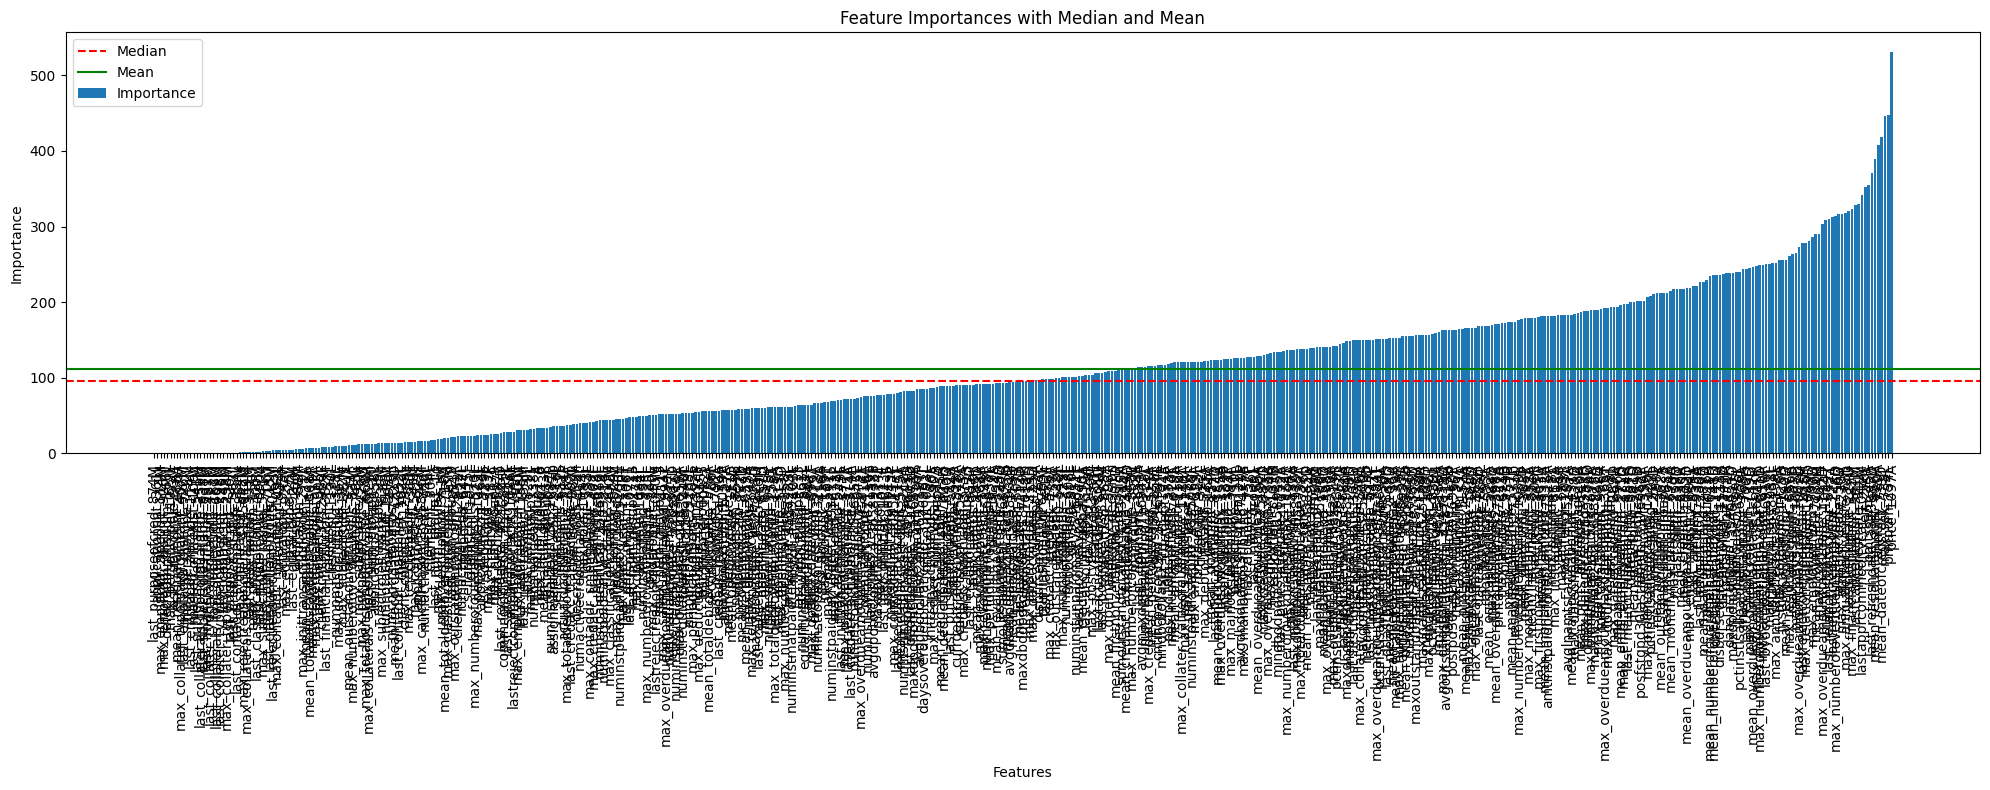

In [21]:
sorted_feature_importances = feature_importances.sort_values(by='importance', ascending=True)
# 中央値と平均値を計算
median_value = sorted_feature_importances['importance'].median()
mean_value = sorted_feature_importances['importance'].mean()

# プロットの作成
plt.figure(figsize=(20, 8))
plt.bar(sorted_feature_importances['feature'], sorted_feature_importances['importance'], label='Importance')
plt.axhline(y=median_value, color='r', linestyle='--', label='Median')
plt.axhline(y=mean_value, color='g', linestyle='-', label='Mean')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances with Median and Mean')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
Learning(df_train, selected_feature_names)

--------------------------------------------------
lightgbm training fold 1
[LightGBM] [Info] Number of positive: 36635, number of negative: 1134229
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.424116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48668
[LightGBM] [Info] Number of data points in the train set: 1170864, number of used features: 262
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031289 -> initscore=-3.432704
[LightGBM] [Info] Start training from score -3.432704
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[1514]	training's auc: 0.929153	valid_1's auc: 0.862222
                         feature  importance
258      mean_pmts_overdue_1140A    0.032901
256          mean_pmts_dpd_1073P    0.029901
111    mean_maxdpdtolerance_577P    0.024588
257           mean_pmts_dpd_303P    0.021653
247         max_incometype_1044T    0.017896
.

In [24]:
def create_submission(test_df, submission_dir, submission_file):
    df_subm = pd.read_csv(submission_dir)
    df_subm.set_index("case_id", inplace=True)
    
    df_subm["score"] = test_df.set_index("case_id")["pred_prob"]
    df_subm.to_csv(submission_file)

test_df = Predicting(df_test, selected_feature_names)
create_submission(test_df, SAMPLE_SUB, "submission.csv")